# Laboratory test data plotting

In [1]:
# Read modules
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# We used R library combined with python.
import rpy2

print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("matplotlib:",mpl.__version__)
print("rpy2:",rpy2.__version__)

%load_ext rpy2.ipython

pandas: 1.3.4
numpy: 1.22.4
matplotlib: 3.6.3
rpy2: 3.5.6


In [2]:
# Set output path
current_path = "/Users/chidakatsuyuki/Desktop/Project/Codes_for_NS_article/"
output_dir = current_path + 'NephroticSyndrome_image/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# Personal data with onset date
personal_path = current_path + "NephroticSyndrome_csv/"
# Checkup data
checkup_path = current_path + "NephroticSyndrome_csv/Checkups.csv"


In [3]:
# Our dataframe for English translation of checkup data
df_en = pd.read_csv(current_path + 'HealthCheckupEnglish_for_R_cp932.csv',encoding="cp932")      
dic_en = dict(zip(df_en.Japanese,df_en.Bind))

# Health checkup data of both group
df_hc = pd.read_csv(checkup_path) 
df_hc.rename(columns=dic_en,inplace=True)

# Change column names into int if possible
def Str_To_Int(x):
    try:
        int(x)  
    except ValueError:
        return x
    else:
        return int(x)
    

# Translate Japanese categorical variables into English ones
df_en.columns = [Str_To_Int(x) for x in df_en.columns]
category_col = df_hc.columns[df_hc.nunique()<11] # We define categorical variables with a variety of 10 or less.
df_en.set_index("Bind", inplace=True)
for col in df_hc.columns:
    if col in category_col:
        df_hc[col] = [df_en.loc[col,x] if ~np.isnan(x) else x for x in df_hc[col]]


In [4]:
# Enrolle IDs in each group and target disease diagnosis date
use_cols = ['Enrollee ID','Target_diag_yyyymm']
df_p=pd.read_csv(personal_path+"patient/individuals.csv",usecols=use_cols)
df_c=pd.read_csv(personal_path+"control/individuals.csv",usecols=use_cols)


# Columns to plot in checkup data
use_cols=["Enrollee ID", "Health examination ymd",
          'Systolic blood pressure (SBP) (mmHg)',
          'Diastolic blood pressure (DPB) (mmHg)',
          'Triglyceride (neutral fat) (mg/dl)', 
          'HDL cholesterol (HDL-C) (mg/dl)',
          'LDL cholesterol (LDL-C) (mg/dl)',
          'Serum uric acid (mg/dl)']

df_p= df_p.merge(df_hc[use_cols],how="left", on ="Enrollee ID")
df_c= df_c.merge(df_hc[use_cols],how="left", on ="Enrollee ID")

In [5]:
# The limit of graph axes
range_dict = {
  "Triglyceride":[80, 140],
  'LDL cholesterol': [80, 140], 
  'HDL cholesterol': [50, 80],
  'Serum uric acid': [4, 7],
  'Diastolic blood pressure': [60, 90],
  'Systolic blood pressure': [100, 140]
}
range_dict = dict(zip([x.replace(" ","_") for x in range_dict.keys()],range_dict.values()))


# Make dictionary to replace column names
rename_dict = dict(zip(
['Triglyceride (neutral fat) (mg/dl)',
 'LDL cholesterol (LDL-C) (mg/dl)',
 'HDL cholesterol (HDL-C) (mg/dl)',
 'Serum uric acid (mg/dl)',
 'Diastolic blood pressure (DPB) (mmHg)',
 'Systolic blood pressure (SBP) (mmHg)'],
    range_dict.keys()))


In [6]:
# For Triglyceride data, a log transformation was applied because of theier skewed distribution.
df_p["Triglyceride (neutral fat) (mg/dl)"] = df_p["Triglyceride (neutral fat) (mg/dl)"].pipe(np.log)
df_c["Triglyceride (neutral fat) (mg/dl)"] = df_c["Triglyceride (neutral fat) (mg/dl)"].pipe(np.log)

# Calculate time from target diagnoses to checkups
df_p["Months_from_diag"] = pd.to_datetime(df_p["Health examination ymd"], format="%Y%m%d"
                                         ).dt.to_period("M").view(int) -pd.to_datetime(df_p['Target_diag_yyyymm'], format="%Y%m"
                                                                                      ).dt.to_period("M").view(int) 
df_c["Months_from_diag"] = pd.to_datetime(df_c["Health examination ymd"], format="%Y%m%d"
                                         ).dt.to_period("M").view(int) -pd.to_datetime(df_c['Target_diag_yyyymm'], format="%Y%m"
                                                                                      ).dt.to_period("M").view(int) 





# Remove a space and a blaket frome column name
df_p.rename(columns=rename_dict,inplace=True)
df_p.columns = df_p.columns.ｓｔｒ.replace(" ","_")
df_c.rename(columns=rename_dict,inplace=True)
df_c.columns = df_c.columns.ｓｔｒ.replace(" ","_")

## Additive models

In [7]:
%%R
require("tidyverse")
require("mgcv")

R[write to console]:  要求されたパッケージ tidyverse をロード中です 



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]:  要求されたパッケージ mgcv をロード中です 

R[write to console]:  要求されたパッケージ nlme をロード中です 

R[write to console]: 
 次のパッケージを付け加えます: ‘nlme’ 


R[write to console]:  以下のオブジェクトは ‘package:dplyr’ からマスクされています: 

     collapse 


R[write to console]: This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.



In [8]:
import itertools
# Hyperparameters
k= 3
bs="tp"

# Use multiindex to show each reguression results concisely
tuples = list(itertools.product(range_dict.keys(),["NS","Control"],["Upper","SE","Center","Lower"])) 
column = pd.MultiIndex.from_tuples(tuples, names=["Variables", "Group", "Plot"])
df_val = pd.DataFrame(index=np.arange(-180,181),columns=column)


# Calculates reggression curves using R mgcv
for col in range_dict.keys():
    for label,df in {"NS":df_p,"Control":df_c}.items():
        %R -i df,col,k,bs df_t<-df %>% select(c("Enrollee_ID",col,"Months_from_diag")) %>% na.omit() # Remove missing on each columns
        %R df_t[["Enrollee_ID"]] <- factor(df_t[["Enrollee_ID"]])
        %R gam <-eval(parse(text=paste0('gam(',col,'~s(Months_from_diag,k=k,bs=bs) + s(Enrollee_ID, bs="re"),data=df_t, se.fit=TRUE)')))
        %R X=seq(-180,180)
        %R y=predict(gam, newdata = list(Months_from_diag=X, Enrollee_ID=rep(1,length(X))), exclude = "s(Enrollee_ID)",se.fit = TRUE)
        %R y$upper=y$fit+1.96*y$se.fit; y$lower=y$fit-1.96*y$se.fit
        %R -o y
        
        # Calculate 95% confidence interbal
        df_val.loc[:,(col,label,"Center")] = y["fit"]
        df_val.loc[:,(col,label,"SE")] = y["se.fit"]
        df_val.loc[:,(col,label,"Upper")] = df_val[col][label]["Center"]+1.96*df_val[col][label]["SE"]
        df_val.loc[:,(col,label,"Lower")] = df_val[col][label]["Center"]-1.96*df_val[col][label]["SE"]
        # Re-convert the velue of triglyceride from a log transformed scale into original-scale
        if col=="Triglyceride":
            for level in df_val[col][label].columns:
                df_val.loc[:,(col,label,level)] = np.exp(df_val[col][label][level])
        else:
            pass

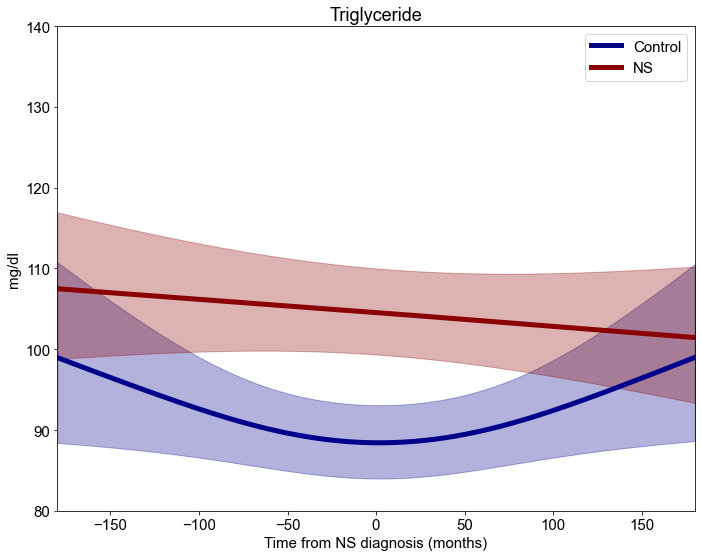

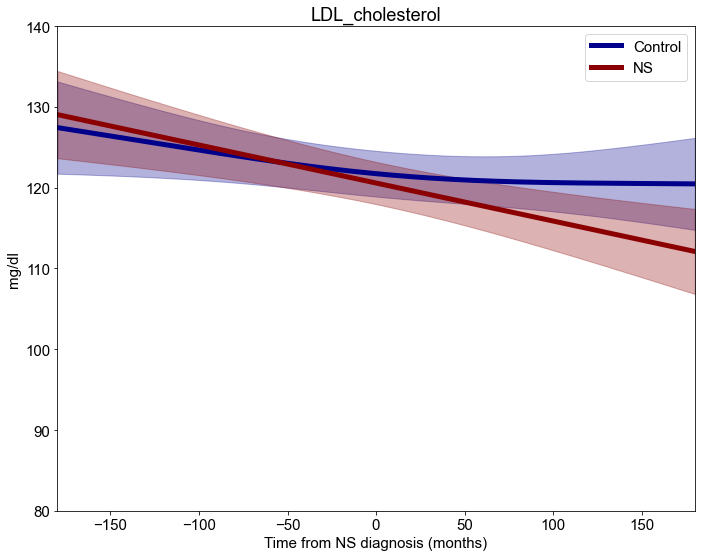

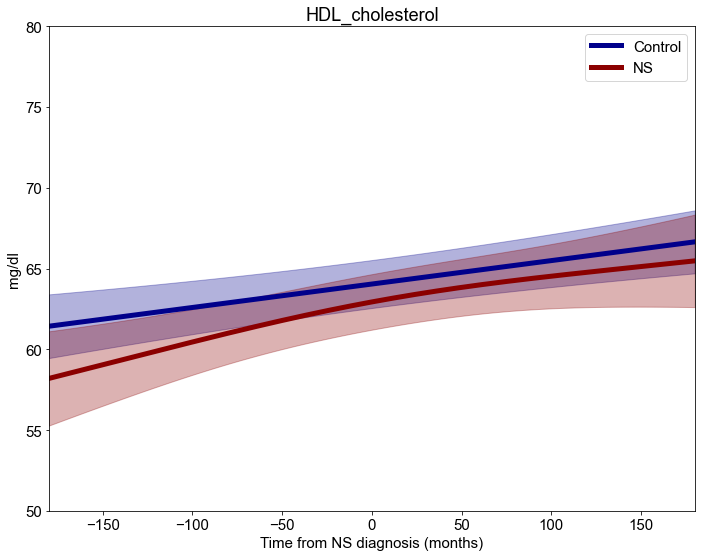

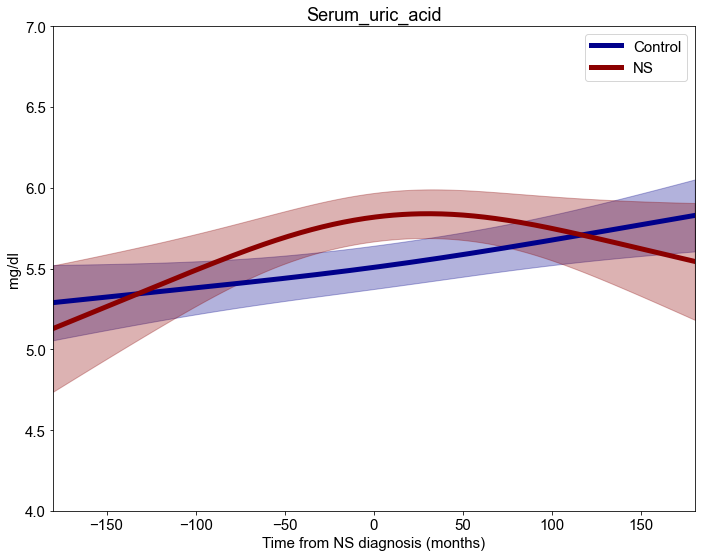

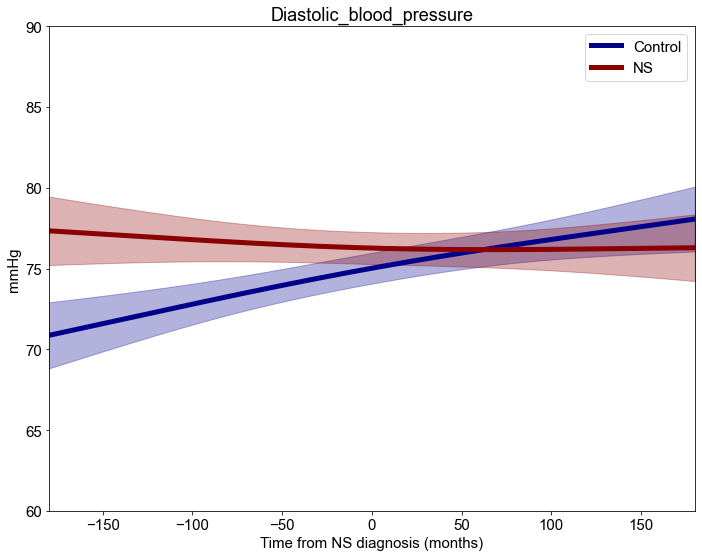

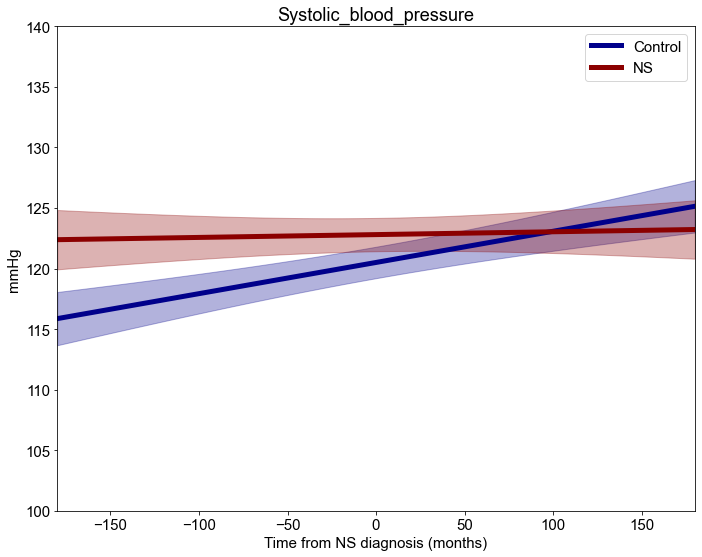

In [10]:
import re
# Drawing plots
font = "Arial"
mpl.rcParams["font.family"] = font
mpl.rcParams["font.size"] = 15

def GetKey(tar_val,dictionary:dict):
    return [key for key, value in dictionary.items() if value == tar_val][0]

for col,ran in range_dict.items():
    fig, ax = plt.subplots(figsize = (10,8))
    
    # Plot results
    df = df_val[col]
    plt.plot(df.index, "Center", data = df["Control"], color = "darkblue", label="Control", lw=5)
    plt.fill_between(df_val.index, "Lower", "Upper", data = df["Control"], color = "darkblue", alpha = 0.3)
    plt.plot(df.index, "Center", data = df["NS"], color = "darkred", label="NS", lw=5)
    plt.fill_between(df_val.index, "Lower", "Upper", data = df["NS"], color = "darkred", alpha = 0.3)
    
    # Set axis scales
    plt.ylim(ran)
    plt.xlim((-180,180))
    plt.xticks([-150,-100,-50,0,50,100,150])
    # Set labels
    value_name = GetKey(col, rename_dict)
    plt.ylabel(re.findall(r'\((.+?)\)',value_name)[-1])
    plt.title(col)
    plt.legend()
    plt.xlabel("Time from NS diagnosis (months)")
    # Output graphs
    plt.tight_layout()
    fig.savefig(f"{output_dir}{col}.pdf")